# OLS vs. Lasso

This notebook presents a simple implementation of Lasso and elastic net regressions. It uses the [OSQP.jl](https://github.com/osqp/OSQP.jl) package for the numerical optimisation.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, LinearAlgebra, SparseArrays, Statistics, OSQP

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))           #pyplot or gr
gr(size=(480,320))
default(fmt = :png)

# Loading Data

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN             = Date.(x[:,1],"yyyy-mm-dd")       #convert to Date
(Rb,RFunds,Rf) = (convert.(Float64,x[:,2:9]),convert.(Float64,x[:,10:11]),
                  convert.(Float64,x[:,12]));     #convert to Float64

# An Elastic Net Regression

minimizes a combination of the Lasso and Ridge regression loss functions

$(Y-Xb)'(Y-Xb)/T + \gamma \sum |b_i-\beta_{i0}| + \lambda \sum (b_i-\beta_{i0})^2$, 

where $\beta_{i0}$ is the target for coefficient $i$ (defaults to 0). Set $\lambda=0$ to get a *Lasso* regression or instead $\gamma=0$ to get a *ridge* regression.

Notice that we divide the sum of squared residuals by $T$. This helps the interpretation of the $\gamma$ and $\lambda$ values.

The problem is reformulated (see the code below) as a linear-quadratic problems with restrictions (see below). The code uses the OSQP solver.

In [4]:
"""
    LassoEN(Y,X,γM=0,λ=0,β₀=0)

Do Lasso (set γ>0,λ=0), ridge (set γ=0,λ>0) or elastic net regression (set γ>0,λ>0). 
The function loops over the values in a vector γM, but requires λ to be a number (scalar).

# Input
- `Y::Vector`:: T-vector, zero mean dependent variable
- `X::Matrix`:  TxK matrix, zero mean regressors
- `γM::Vector`: nγ-vector with different values of γ (could also be a number)
- `λ::Number`:  value of λ (a number)
- `β₀::Vector`: K-vector of target levels for the coeffs (could also be a common number)


# Remark (details on the coding)

Choice variables z = [b;u,t] with lengths K,T,K respectively

The objective 0.5*z'P*z + q'z effectively involves
0.5*z'P*z = 0.5*2λb'b + 0.5*2u'u/T and q'z = -2λβ₀'b + γ1't

The restrictions lb <= Az <= ub imply
Y  <= Xβ + u <= Y
-∞ <= β-t    <= β₀
β₀ <= β-t    <= ∞

# Requires
using OSQP, SparseArrays, LinearAlgebra

"""
function LassoEN(Y,X,γM=0,λ=0,β₀=0)

  (T,K) = (size(X,1),size(X,2))
  nγ = length(γM)

  b_ls = X\Y
  βM₀ = isa(β₀,Number) ? fill(β₀,K) : β₀     #exand to vector, if needed
  
  P = blockdiag(sparse(2*λ*I,K,K),sparse(2I/T,T,T),spzeros(K,K)) #2* to cancel the 0.5 in 0.5z'Pz
  q = [-2*λ*βM₀;zeros(T+K)]
  A = [sparse(X)     sparse(I,T,T)  spzeros(T,K);
       sparse(I,K,K) spzeros(K,T)  -sparse(I,K,K);
       sparse(I,K,K) spzeros(K,T)   sparse(I,K,K)]
  lb = [Y; fill(-Inf,K); βM₀]
  ub = [Y; βM₀; fill(Inf,K)]

  prob = OSQP.Model()

  settings = Dict(:verbose => false)
  OSQP.setup!(prob;P=P,q=q,A=A,l=lb,u=ub,settings...)

  bM   = fill(NaN,K,nγ)               #loop over γ values
  for i = 1:nγ
    q[end-K+1:end] .= γM[i]              #change q
    OSQP.update!(prob;q=q)
    res = OSQP.solve!(prob)
    (res.info.status == :Solved) && (bM[:,i] = res.x[1:K])
  end
  
  return bM, b_ls

end

LassoEN

# Lasso Regression

The next cell makes a Lasso regression for a single value of γ. The dependent variable is the (return of the) first mutual fund in `RFunds` (see data loading) and the regressors are (returns on) a number of benchmark portfolios (again, see data loading).

The data is standardised (zero mean, unit variance) before the estimation.

In [5]:
function StandardiseYX(Y0,X0)             #Lasso regressions are often applied
    Y = (Y0 .- mean(Y0))/std(Y0)          #to standardised data
    X = (X0 .- mean(X0,dims=1))./std(X0,dims=1)
    return Y,X
end

(Y,X) = StandardiseYX(RFunds[:,1],Rb)

γ = 0.05

(b,b_ls) = LassoEN(Y,X,γ)

printblue("OLS and Lasso coeffs (with γ=$γ):\n")
printmat([b_ls b],colNames=["OLS" "Lasso"],rowNames=IndNames,width=15)

OLS and Lasso coeffs (with γ=0.05):

                                      OLS          Lasso
S&P 500                             0.513          0.502
S&P MidCap 400                      0.117          0.127
S&P Small Cap 600                   0.097          0.080
World Developed - Ex. U.S.          0.239          0.244
Emerging Markets                    0.080          0.077
US Corporate Bonds                  0.061          0.001
U.S. Treasury Bills                 0.002          0.000
US Treasury                        -0.045          0.001



# Redo the Lasso Regression with different γ (gamma) Values

The function `LassoEN()` can loop over $\gamma$ values (and exploit the fact that this only requires a partial updating of the problem).

You can also change the target level $\beta_0$ to be something else than zero.

In [6]:
nγ = 51
γM = range(0,0.5,length=nγ)
β₀ = 0.0     #change to eg. 0.1 to set another target, or specify a vector

bLasso, = LassoEN(Y,X,γM,0,β₀);
#printmat([γM bLasso'])

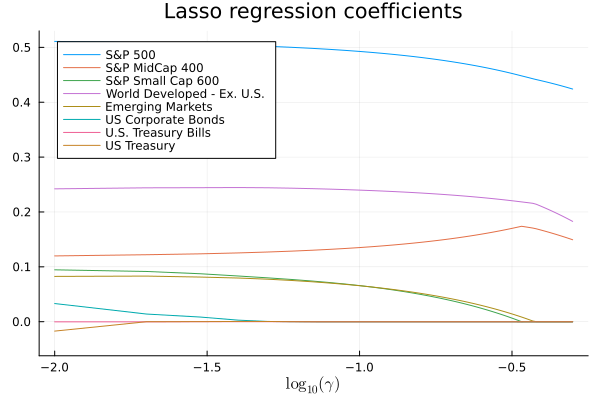

In [7]:
p1 = plot( log10.(γM),bLasso',
           title = "Lasso regression coefficients",
           xlabel = L"\log_{10}(\gamma)",
           label = permutedims(IndNames),
           legend = :topleft,
           size = (600,400) )
display(p1)

# A Ridge Regression

minimizes $(Y-Xb)'(Y-Xb)/T + \lambda \sum (b_i-\beta_{i0})^2$, where $\beta_{i0}$ is the target for coefficient $i$ (defaults to 0). We compare analytical and numerical results.

In [8]:
"""
    RidgeRegression(Y,X,λ,β₀=0)

Calculate ridge regression estimate with targetr vector β₀.
"""
function RidgeRegression(Y,X,λ,β₀=0)
    (T,K) = (size(X,1),size(X,2))
    isa(β₀,Number) && (β₀=fill(β₀,K))
    b = (X'X/T+λ*I)\(X'Y/T+λ*β₀)      #same as inv(X'X/T+λ*I)*(X'Y/T+λ*β₀)
    return b
end

RidgeRegression

In [9]:
β₀ = 0              #change to eg. 0.1 to set another target

b_LS     = X\Y
b_ridge  = RidgeRegression(Y,X,0.1,β₀)
b_ridge2, = LassoEN(Y,X,0,0.1,β₀)

printblue("OLS and ridge regression:\n")
printmat([b_ls b_ridge b_ridge2],colNames=["OLS","analytical ridge","numerical ridge"],rowNames=IndNames,width=20)

OLS and ridge regression:

                                           OLS    analytical ridge     numerical ridge
S&P 500                                  0.513               0.375               0.375
S&P MidCap 400                           0.117               0.192               0.192
S&P Small Cap 600                        0.097               0.129               0.129
World Developed - Ex. U.S.               0.239               0.229               0.229
Emerging Markets                         0.080               0.102               0.102
US Corporate Bonds                       0.061               0.048               0.048
U.S. Treasury Bills                      0.002              -0.001              -0.001
US Treasury                             -0.045              -0.036              -0.036



In [10]:
nλ = 51
λM = range(0,10,length=nλ)

bridge   = fill(NaN,size(X,2),nλ) 
for i = 1:nλ                          #loop over λ values
    bridge[:,i] = RidgeRegression(Y,X,λM[i])
end

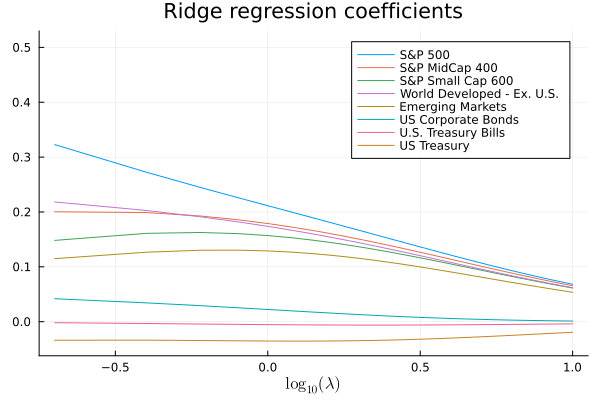

In [11]:
p1 = plot( log10.(λM),bridge',
           title = "Ridge regression coefficients",
           xlabel = L"\log_{10}(\lambda)",
           label = permutedims(IndNames),
           size = (600,400) )
display(p1)

# An Elastic Net Regression

In [12]:
λ = 0.2
bEN, = LassoEN(Y,X,γM,λ);

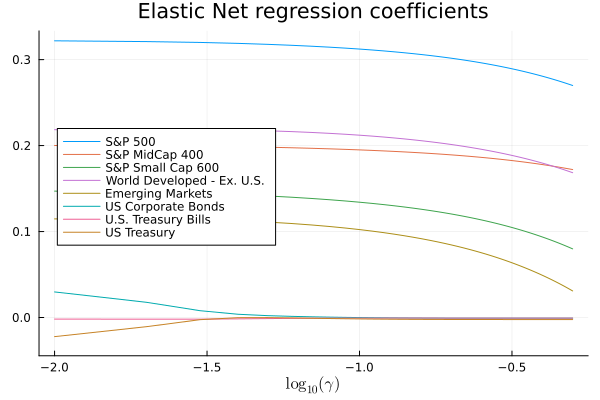

In [13]:
p1 = plot( log10.(γM),bEN',
           title = "Elastic Net regression coefficients",
           xlabel = L"\log_{10}(\gamma)",
           label = permutedims(IndNames),
           legend = :left,
           size = (600,400) )
display(p1)